# **Machine Learning using Grammatical Evolution**
### Classification of mammogram segments as containing or not containing suspicious growth. 
Ranya El-Hwigi 18227449

### ***Clone GRAPE repository***

In [2]:
import os.path

In [3]:
PATH = '/users/ranyahwigi/desktop/FYP/grape'
if os.path.exists(PATH):
    print('grape directory already exists')
else:
    !git clone https://github.com/UL-BDS/grape.git 
    print('Cloning grape in your Drive')

%cd /users/ranyahwigi/desktop/FYP/grape/

grape directory already exists
/Users/ranyahwigi/Desktop/FYP/grape


In [4]:
# Suppressing Warnings:
import warnings
warnings.filterwarnings("ignore")

### **Importing libraries**

In [5]:
!pip install deap
!pip install numpy
!pip install -U imbalanced-learn

import algorithms
from ponyge2_adapted_files import Grammar, ge
from functions import add, sub, mul, pdiv, neg

import numpy as np
from os import path
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from deap import creator, base, tools
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import math

### **Preparing data**

Loading dataset

In [6]:
# loading in the dataset into a pandas dataframe from GitHub
data = pd.read_csv('https://media.githubusercontent.com/media/relhwigi/GE_GRAPE_Mammogram_Classification/main/data/haralick02_250K.csv')

Dropping columns from dataset

In [7]:
data.drop(['PatientID', 'StudyID', 'PatientAge', 'ImgID', 'View', 'SegmentPosition'], axis=1, inplace=True)

Number of samples

In [9]:
number_of_samples = data['x0'].count()

Number of columns remaining

In [10]:
final_number_of_columns = len(data.columns)

Train and test split

In [11]:
X = np.zeros([number_of_samples, final_number_of_columns-1], dtype=float)
Y = np.zeros([number_of_samples,], dtype=int)

for i in range(number_of_samples):
    for j in range(final_number_of_columns-1):
        X[i,j] = data['x'+ str(j)].iloc[i]

for i in range(number_of_samples):
    Y[i] = data['Label'].iloc[i]

oversample = SMOTE()
X, Y = oversample.fit_resample(X, Y)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

print('Training (X,Y):\t', X_train.shape, Y_train.shape)
print('Test (X,Y):\t', X_test.shape, Y_test.shape)

X_train = np.transpose(X_train)
X_test = np.transpose(X_test)

Training (X,Y):	 (33625, 104) (33625,)
Test (X,Y):	 (14411, 104) (14411,)


### **Defining the Fitness Function**

In [48]:
def fitness_eval(individual, points):
  x= points[0]
  Y= points[1]

  if individual.invalid==True:
    return np.NaN,

  try:
    pred= eval(individual.phenotype)
  except (FloatingPointError, ZeroDivisionError, OverflowError, MemoryError):
    return np.NaN,
  assert np.isrealobj(pred)

  try:
    Y_class= [1 if pred[i] > 0 else 0 for i in range(len(Y))]
  except (IndexError, TypeError):
    return np.NaN,

  # TP -> True Positive, FP -> False Posititve, TN -> True Negative, FN -> False Negtaive
  # 0 -> negative, 1 -> positive

  TP, FN, TN, FP = 0, 0, 0, 0

  for x, y in zip(Y, Y_class):
    if x == 1:
      if y == 1:
        TP = TP + 1
      else:
        FN = FN + 1
    elif x == 0:
      if y == 0:
        TN = TN + 1
      else:
        FP = FP + 1

  if FN == 0 and TN == 0:
    return np.NaN,
  elif FP == 0 and TP == 0:
    return np.NaN,
  else:
    # Calculating Accuracy
    numerator = (TP+TN)
    denominator = (TP+TN+FP+FN)
    fitness = numerator / denominator

  return fitness,

### **Defining Grammar**

Checking grammar file

In [46]:
f = open("../GE_GRAPE_Mammogram_Classification/grammar_old.bnf", "r")
print(f.read())
f.close() 

<e> ::= add(<segment_a>,<segment_b>)|sub(<segment_a>,<segment_b>)|pdiv(<segment_a>,<segment_b>)|mul(<segment_a>,<segment_b>)|<decimal>|<segment_a>|add(<segment_b>,<segment_a>)|sub(<segment_b>,<segment_a>)|pdiv(<segment_b>,<segment_a>)|mul(<segment_b>,<segment_a>)|<segment_b>
<decimal> ::= <n><n>.<n><n>
<segment_a> ::= x[0]|x[1]|x[2]|x[3]|x[4]|x[5]|x[6]|x[7]|x[8]|x[9]|x[10]|x[11]|x[12]|x[13]|x[14]|x[15]|x[16]|x[17]|x[18]|x[19]|x[20]|x[21]|x[22]|x[23]|x[24]|x[25]|x[26]|x[27]|x[28]|x[29]|x[30]|x[31]|x[32]|x[33]|x[34]|x[35]|x[36]|x[37]|x[38]|x[39]|x[40]|x[41]|x[42]|x[43]|x[44]|x[45]|x[46]|x[47]|x[48]|x[49]|x[50]|x[51]
<segment_b> ::= x[52]|x[53]|x[54]|x[55]|x[56]|x[57]|x[58]|x[59]|x[60]|x[61]|x[62]|x[63]|x[64]|x[65]|x[66]|x[67]|x[68]|x[69]|x[70]|x[71]|x[72]|x[73]|x[74]|x[75]|x[76]|x[77]|x[78]|x[79]|x[80]|x[81]|x[82]|x[83]|x[84]|x[85]|x[86]|x[87]|x[88]|x[89]|x[90]|x[91]|x[92]|x[93]|x[94]|x[95]|x[96]|x[97]|x[98]|x[99]|x[100]|x[101]|x[102]|x[103]
<n> ::= 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9


Declare grammar

In [47]:
BNF_GRAMMAR = Grammar("../GE_GRAPE_Mammogram_Classification/grammar_old.bnf")

         Unit productions consume GE codons.


### ***Grammatical Evolution***

Setting GE parameters

In [67]:
POPULATION_SIZE = 200
MAX_GENERATIONS = 100
P_CROSSOVER = 0.8
P_MUTATION = 0.2
ELITE_SIZE = round(0.1*POPULATION_SIZE)
HALL_OF_FAME_SIZE = 10
MAX_INIT_TREE_DEPTH = 8
MIN_INIT_TREE_DEPTH = 2
MAX_TREE_DEPTH = 10
MAX_WRAPS = 0
CODON_SIZE = 255

Creating DEAP toolbox

In [68]:
toolbox = base.Toolbox()
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create('Individual', ge.Individual, fitness=creator.FitnessMax)
toolbox.register("populationCreator", ge.initialisation_PI_Grow, creator.Individual) 
toolbox.register("evaluate", fitness_eval)
toolbox.register("select", ge.selTournament, tournsize=10)
toolbox.register("mate", ge.crossover_onepoint)
toolbox.register("mutate", ge.mutation_int_flip_per_codon)

Main function

In [69]:
population = toolbox.populationCreator(size=POPULATION_SIZE, 
                                        bnf_grammar=BNF_GRAMMAR, 
                                        min_init_tree_depth=MIN_INIT_TREE_DEPTH,
                                        max_init_tree_depth=MAX_INIT_TREE_DEPTH,
                                        max_tree_depth=MAX_TREE_DEPTH, 
                                        max_wraps=MAX_WRAPS,
                                        codon_size=CODON_SIZE
                                        )

hof = tools.HallOfFame(HALL_OF_FAME_SIZE)

stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register("avg", np.nanmean)
stats.register("std", np.nanstd)
stats.register("min", np.nanmin)
stats.register("max", np.nanmax)

population, logbook = algorithms.ge_eaSimpleWithElitism(population, toolbox, cxpb=P_CROSSOVER, mutpb=P_MUTATION,
                                                        ngen=MAX_GENERATIONS, elite_size=ELITE_SIZE,
                                                        bnf_grammar=BNF_GRAMMAR, codon_size=CODON_SIZE, 
                                                        max_tree_depth=MAX_TREE_DEPTH, max_wraps=MAX_WRAPS,
                                                        points_train=[X_train, Y_train], 
                                                        points_test=[X_test, Y_test], 
                                                        stats=stats, halloffame=hof, verbose=True)

gen	invalid	avg     	std      	min     	max     	fitness_test	best_ind_length	avg_length	max_length	selection_time	generation_time
0  	0      	0.510122	0.0130298	0.474677	0.537487	0.474846    	4              	5.055     	9         	0             	2.97116        
1  	25     	0.507045	0.0164232	0.470959	0.547331	0.53709     	4              	5.015     	12        	0.00175595    	2.57112        
2  	13     	0.512569	0.0173218	0.470959	0.547331	0.53709     	7              	5.435     	13        	0.00181603    	2.80916        
3  	13     	0.511035	0.0189788	0.449903	0.535197	0.53709     	7              	5.69      	15        	0.00177169    	3.10063        
4  	10     	0.513147	0.0206256	0.449903	0.538349	0.53709     	7              	6.25      	13        	0.00178409    	3.2094         
5  	8      	0.511965	0.0226506	0.449903	0.54513 	0.53709     	7              	6.61      	14        	0.00174403    	3.51459        
6  	5      	0.512186	0.0227686	0.449903	0.549978	0.534453    	7              	7.415

62 	0      	0.514495	0.0333195	0.440059	0.549978	0.534453    	8              	21.47     	35        	0.00175619    	3.19354        
63 	0      	0.511527	0.0322605	0.440059	0.549978	0.534453    	8              	21.315    	36        	0.00180197    	3.27008        
64 	0      	0.513913	0.0312527	0.440059	0.549978	0.534453    	8              	20.985    	34        	0.00178814    	3.38392        
65 	0      	0.515902	0.0326372	0.440059	0.549978	0.534453    	8              	21.04     	33        	0.00174737    	3.23957        
66 	0      	0.51908 	0.0324074	0.440059	0.549978	0.534453    	8              	21.4      	34        	0.00176525    	3.14478        
67 	0      	0.513447	0.0333798	0.440059	0.549978	0.534453    	8              	20.43     	34        	0.00177503    	3.17619        
68 	0      	0.517312	0.0333327	0.440059	0.549978	0.534453    	8              	20.845    	35        	0.00178218    	3.15843        
69 	0      	0.516594	0.0338729	0.440059	0.549978	0.534453    	8              	20.2 

Statistics

In [70]:
max_fitness_values, mean_fitness_values = logbook.select("max", "avg")
min_fitness_values, std_fitness_values = logbook.select("min", "std")
fitness_test = logbook.select("fitness_test")
best_ind_length = logbook.select("best_ind_length")
avg_length = logbook.select("avg_length")
max_length = logbook.select("max_length")
selection_time = logbook.select("selection_time")
generation_time = logbook.select("generation_time")
gen, invalid = logbook.select("gen", "invalid")

header = ['gen', 'invalid', 'avg', 'std', 'min', 'max', 'fitness_test', 'best_ind_length', 'avg_length', 'max_length', 'selection_time', 'generation_time']

results = pd.DataFrame(list(zip(gen, invalid, mean_fitness_values, std_fitness_values, min_fitness_values, max_fitness_values, fitness_test, best_ind_length, avg_length, max_length, selection_time, generation_time)),
               columns = header)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 10000)
pd.set_option('display.colheader_justify', 'center')

display(results)

,gen,invalid,avg,std,min,max,fitness_test,best_ind_length,avg_length,max_length,selection_time,generation_time
0,0,0,0.510122,0.013030,0.474677,0.537487,0.474846,4,5.055,9,0.000000,2.971159
1,1,25,0.507045,0.016423,0.470959,0.547331,0.537090,4,5.015,12,0.001756,2.571121
2,2,13,0.512569,0.017322,0.470959,0.547331,0.537090,7,5.435,13,0.001816,2.809163
3,3,13,0.511035,0.018979,0.449903,0.535197,0.537090,7,5.690,15,0.001772,3.100626
4,4,10,0.513147,0.020626,0.449903,0.538349,0.537090,7,6.250,13,0.001784,3.209398
5,5,8,0.511965,0.022651,0.449903,0.545130,0.537090,7,6.610,14,0.001744,3.514586
6,6,5,0.512186,0.022769,0.449903,0.549978,0.534453,7,7.415,14,0.001763,3.262186
7,7,2,0.513151,0.023567,0.449903,0.549978,0.534453,7,7.730,14,0.001762,3.523432
8,8,3,0.513931,0.026615,0.449903,0.549978,0.534453,8,8.345,16,0.001723,3.196216
9,9,1,0.511407,0.028119,0.449903,0.549978,0.534453,8,8.770,16,0.001714,3.325008


Best individual

In [71]:
print("Best individual:")
print(hof.items[0].phenotype)
print()
print("Training Fitness: ", hof.items[0].fitness.values[0])
print()
print("Depth: ", hof.items[0].depth)
print()
print("Length of the genome: ", len(hof.items[0].genome))
print()
print(f'Used portion of the genome: {hof.items[0].used_codons/len(hof.items[0].genome):.2f}')
print()

Best individual:
sub(x[0],x[52])

Training Fitness:  0.5499776951672862

Depth:  3

Length of the genome:  8

Used portion of the genome: 0.38



### ***Testing Best Individual***

Calculating predictions

In [12]:
predictions = sub(X_test[0],X_test[52])

In [13]:
print(predictions)

[-0.12009112  0.00274693 -0.00160271 ...  0.0030084   0.00829192
 -0.00894226]


Classifying to labels

In [14]:
Y_prediction_class= [1 if predictions[i] > 0 else 0 for i in range(len(predictions))]

In [15]:
print(Counter(Y_prediction_class))

Counter({1: 7823, 0: 6588})


Calculating Confusion Matrix

In [16]:
TP, FN, TN, FP = 0, 0, 0, 0
for x, y in zip(Y_test, Y_prediction_class):
  if x == 0:
    if y == 0:
      TN = TN + 1
    else:
      FP = FP + 1
  elif x == 1:
    if y == 1:
      TP = TP + 1
    else:
      FN = FN + 1

Accuracy

In [17]:
numerator = (TP+TN)
denominator = (TP+TN+FP+FN)
accuracy = numerator / denominator
accuracy

0.536465200194296

True Positive Rate

In [18]:
TPR = TP/(TP+FN)
TPR

0.5793199167244969

True Negative Rate

In [19]:
TNR = TN/(TN+FP)
TNR

0.493616430752151

False Positive Rate

In [20]:
FPR = FP/(FP+TN)
FPR

0.506383569247849

False Negative Rate

In [21]:
FNR = FN/(FN+TP)
FNR

0.4206800832755031

Area Under the Curve

In [22]:
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(Y_test, Y_prediction_class)
auc

0.5364681737383239

**Best individuals plots**

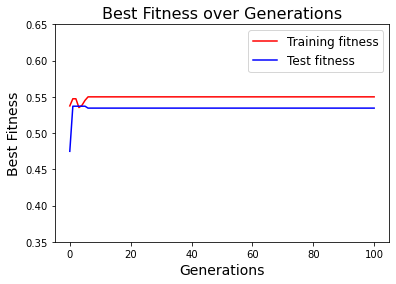

In [86]:
plt.plot(gen, max_fitness_values, color='red', label="Training fitness")
plt.plot(gen, fitness_test, color='blue', label="Test fitness")
plt.legend(fontsize=12)
plt.xlabel('Generations', fontsize=14)
plt.ylabel('Best Fitness', fontsize=14)
plt.title('Best Fitness over Generations', fontsize=16)
plt.yticks(np.arange(0.35, 0.67, 0.05))
plt.show()

**Average fitness plot**

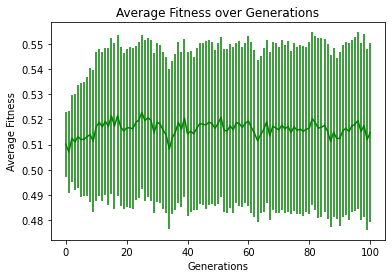

In [87]:
plt.xlabel('Generations')
plt.ylabel('Average Fitness')
plt.title('Average Fitness over Generations')
plt.errorbar(gen, mean_fitness_values, yerr=std_fitness_values,label="Best", color="Green")
plt.show()

**Genome length plots**

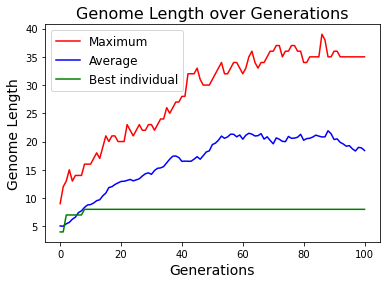

In [88]:
plt.plot(gen, max_length, color='red', label="Maximum")
plt.plot(gen, avg_length, color='blue', label="Average")
plt.plot(gen, best_ind_length, color='green', label="Best individual")
plt.legend(fontsize=12)
plt.xlabel('Generations', fontsize=14)
plt.ylabel('Genome Length', fontsize=14)
plt.title('Genome Length over Generations', fontsize=16)
plt.show()